In [61]:
import os
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
#from torchvision.datasets import MNIST
#import torchvision.transforms as transforms
from torch.utils.data import Dataset
import spacy
#import pytorch_lightning as pl
#from pytorch_lightning import Trainer
import matplotlib.pyplot as plt
import numpy as np
from scipy import linalg
import scipy
from sklearn.manifold import TSNE
import sklearn
from sklearn.linear_model import LinearRegression, Ridge, SGDClassifier
from sklearn.svm import LinearSVC, SVR
from sklearn.multioutput import MultiOutputRegressor
#from sklearn.datasets import fetch_mldata
from sklearn.decomposition import PCA
import scipy.io
import random
import inlp
from sklearn.manifold import TSNE
import matplotlib
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import torch
from transformers import BertTokenizer, BertModel, BertForMaskedLM, BertConfig
from typing import Tuple, Dict
from typing import List
import tqdm
from tqdm import tqdm_notebook
import urllib
import time
import pickle
import inlp, inlp_dataset_handler, inlp_linear_model
import copy
%load_ext autoreload
%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
def load_wiki(url = "http://nlp.biu.ac.il/~ravfogs/resources/wiki.1million.raw.txt"):
    
  response = urllib.request.urlopen(url)
  raw = response.read().decode('utf8')
  sents = raw.split("\n")
  
  return sents[:]


def create_docs(sentences: List[str]) -> List[spacy.tokens.Doc]:

    #parsing and toekenizing (NOTE: takes about 10 minutes)
    
    nlp = spacy.load('en_core_web_sm')
    nlp.remove_pipe("ner")
    
    start = time.time()
    
    docs = list(nlp.pipe(sentences, batch_size = 100))
    
    docs = list(docs)
    print(time.time() - start)
    
    return docs


def collect_rec_dataset(docs, n):
    
    contain_rec = []
    for i, doc in tqdm_notebook(enumerate(docs), total = len(docs)):
        deps = [tok.dep_ for tok in doc]
        if "relcl" in deps:
            contain_rec.append(doc)
    
    contain_rec_set = set(contain_rec)
    no_rec = [d for d in docs if d not in contain_rec_set]
    data = []
    for i in range(n):
        data.append((random.choice(contain_rec), 1))
        data.append((random.choice(no_rec), 0))
    
    random.shuffle(data)
    return data
    

In [6]:
wiki_sents = load_wiki()

In [7]:
wiki_sents = wiki_sents[:200000]
docs = create_docs(wiki_sents)

280.4957218170166


In [13]:
d = create_docs(["the man that I see is here"])

0.027721166610717773


In [9]:
with open("sents.pickle", "wb") as f:
    pickle.dump(wiki_sents, f)
    
with open("docs.pickle", "wb") as f:
    pickle.dump(docs, f)

In [56]:
with open("docs.pickle", "rb") as f:
    docs = pickle.load(f)

In [97]:
data = collect_rec_dataset(docs, n = 25000)

/home/shauli/anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:30: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [98]:
for d in data[:10]:
    print(d)

(einstein, who conducted themselves in a civil and thoughtful manner with the goal of clarifying the presentation of qm, and not to score points, unlike the present participants on sol, who demonstrate none of these qualities., 1)
(british naval intelligence had been aware of the arms shipment, casement 's return, and the easter date for the rising through radio messages between germany and its embassy in the united states that were intercepted by the navy and deciphered in room 40 of the admiralty., 1)
(the b-side of the finnish version is a cover of the accept song, ``midnight mover'', which was recorded in 2003 in a radio studio during a live broadcast., 1)
(uctv is a particularly useful tool for any university in the uk that wants to be seen as taking active steps to widen its participation., 1)
(whoever that comes in and cleans it up will be left with unfortunate decisions that will be disagreed with., 1)
(it was built in 1924 to serve as a home for elderly widows., 0)
(the album 

## Encoder

In [117]:
class BertEncoder(object):
    
    def __init__(self, device = 'cpu'):

        config = BertConfig.from_pretrained("bert-large-uncased", output_hidden_states=True)
        self.tokenizer = BertTokenizer.from_pretrained('bert-large-uncased')
        self.model = BertModel.from_pretrained('bert-large-uncased', config = config)
            
        self.model.eval()
        self.model.to(device)
        self.device = device
        
    def tokenize(self, original_sentence: List[str]) -> Tuple[List[str], Dict[int, int]]:

        """
        Parameters
        ----------
        Returns
        -------
        bert_tokens: The sentence, tokenized by BERT tokenizer.
        orig_to_tok_map: An output dictionary consisting of a mapping (alignment) between indices in the original tokenized sentence, and indices in the sentence tokenized by the BERT tokenizer. See https://github.com/google-research/bert
        """

        bert_tokens = ["[CLS]"]
        orig_to_tok_map = {}
        has_subwords = False
        is_subword = []

        for i, w in enumerate(original_sentence):
            tokenized_w = self.tokenizer.tokenize(w)
            has_subwords = len(tokenized_w) > 1
            is_subword.append(has_subwords)
            bert_tokens.extend(tokenized_w)

            orig_to_tok_map[i] = len(bert_tokens) - 1

        bert_tokens.append("[SEP]")
        
        return (bert_tokens, orig_to_tok_map)

    
    def encode(self, sentence: str, layers: List[int]):
        
        tokenized_text, orig2tok = self.tokenize(sentence.split(" "))
        indexed_tokens = self.tokenizer.convert_tokens_to_ids(tokenized_text)
        tokens_tensor = torch.tensor([indexed_tokens]).to(self.device)

        with torch.no_grad():
            outputs = self.model(tokens_tensor)
            predictions = torch.cat([outputs[2][l] for l in layers], axis = 2).detach().cpu().numpy()
            
            """
            if layer >= 0:
                predictions = outputs[2][layer].detach().cpu().numpy()
            else:
                concat = torch.cat(outputs[2], axis = 0)
                concat = concat[:7, :, :]
                predictions = concat.reshape(concat.shape[1], concat.shape[0] * concat.shape[2])
                
                print(predictions.shape)
                print("----------------------------")
                #predictions = torch.sum(concat, axis = 0).detach().cpu().numpy()
            """
            return (predictions.squeeze(), orig2tok)
        

def collect_bert_states(bert, data: List[Tuple], layers: List[int]):
    
    
    for i,d in tqdm_notebook(enumerate(data), total = len(data)):
        
        doc, label = d
        sent = " ".join([tok.text for tok in doc])
        preds, orig2tok = bert.encode(sent, layers = layers)

        cls_state = preds[0]
        data[i] = (doc, cls_state, label)
    
    return data


In [ ]:
bert = BertEncoder(device = "cpu")
print(len(data))
data_with_bert_states = collect_bert_states(bert, copy.deepcopy(data[:10000]), layers = [6])

INFO:filelock:Lock 140077815426768 acquired on /home/shauli/.cache/torch/transformers/6dfaed860471b03ab5b9acb6153bea82b6632fb9bbe514d3fff050fe1319ee6d.fc076a4d5f1edf25ea3a2bd66e9f6f295dcd64c81dfef5b3f5a3eb2a82751ad1.lock
INFO:transformers.file_utils:https://s3.amazonaws.com/models.huggingface.co/bert/bert-large-uncased-config.json not found in cache or force_download set to True, downloading to /home/shauli/.cache/torch/transformers/tmp8sxstcmz


INFO:transformers.file_utils:storing https://s3.amazonaws.com/models.huggingface.co/bert/bert-large-uncased-config.json in cache at /home/shauli/.cache/torch/transformers/6dfaed860471b03ab5b9acb6153bea82b6632fb9bbe514d3fff050fe1319ee6d.fc076a4d5f1edf25ea3a2bd66e9f6f295dcd64c81dfef5b3f5a3eb2a82751ad1
INFO:transformers.file_utils:creating metadata file for /home/shauli/.cache/torch/transformers/6dfaed860471b03ab5b9acb6153bea82b6632fb9bbe514d3fff050fe1319ee6d.fc076a4d5f1edf25ea3a2bd66e9f6f295dcd64c81dfef5b3f5a3eb2a82751ad1
INFO:filelock:Lock 140077815426768 released on /home/shauli/.cache/torch/transformers/6dfaed860471b03ab5b9acb6153bea82b6632fb9bbe514d3fff050fe1319ee6d.fc076a4d5f1edf25ea3a2bd66e9f6f295dcd64c81dfef5b3f5a3eb2a82751ad1.lock
INFO:transformers.configuration_utils:loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-large-uncased-config.json from cache at /home/shauli/.cache/torch/transformers/6dfaed860471b03ab5b9acb6153bea82b6632fb9bbe514d3fff0

INFO:transformers.file_utils:storing https://s3.amazonaws.com/models.huggingface.co/bert/bert-large-uncased-vocab.txt in cache at /home/shauli/.cache/torch/transformers/9b3c03a36e83b13d5ba95ac965c9f9074a99e14340c523ab405703179e79fc46.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084
INFO:transformers.file_utils:creating metadata file for /home/shauli/.cache/torch/transformers/9b3c03a36e83b13d5ba95ac965c9f9074a99e14340c523ab405703179e79fc46.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084
INFO:filelock:Lock 140077800002064 released on /home/shauli/.cache/torch/transformers/9b3c03a36e83b13d5ba95ac965c9f9074a99e14340c523ab405703179e79fc46.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084.lock
INFO:transformers.tokenization_utils:loading file https://s3.amazonaws.com/models.huggingface.co/bert/bert-large-uncased-vocab.txt from cache at /home/shauli/.cache/torch/transformers/9b3c03a36e83b13d5ba95ac965c9f9074a99e14340c523ab405703179e79fc46.542ce4

INFO:filelock:Lock 140077815958544 acquired on /home/shauli/.cache/torch/transformers/54da47087cc86ce75324e4dc9bbb5f66c6e83a7c6bd23baea8b489acc8d09aa4.4d5343a4b979c4beeaadef17a0453d1bb183dd9b084f58b84c7cc781df343ae6.lock
INFO:transformers.file_utils:https://s3.amazonaws.com/models.huggingface.co/bert/bert-large-uncased-pytorch_model.bin not found in cache or force_download set to True, downloading to /home/shauli/.cache/torch/transformers/tmpdsaqs6li


INFO:transformers.file_utils:storing https://s3.amazonaws.com/models.huggingface.co/bert/bert-large-uncased-pytorch_model.bin in cache at /home/shauli/.cache/torch/transformers/54da47087cc86ce75324e4dc9bbb5f66c6e83a7c6bd23baea8b489acc8d09aa4.4d5343a4b979c4beeaadef17a0453d1bb183dd9b084f58b84c7cc781df343ae6
INFO:transformers.file_utils:creating metadata file for /home/shauli/.cache/torch/transformers/54da47087cc86ce75324e4dc9bbb5f66c6e83a7c6bd23baea8b489acc8d09aa4.4d5343a4b979c4beeaadef17a0453d1bb183dd9b084f58b84c7cc781df343ae6
INFO:filelock:Lock 140077815958544 released on /home/shauli/.cache/torch/transformers/54da47087cc86ce75324e4dc9bbb5f66c6e83a7c6bd23baea8b489acc8d09aa4.4d5343a4b979c4beeaadef17a0453d1bb183dd9b084f58b84c7cc781df343ae6.lock
INFO:transformers.modeling_utils:loading weights file https://s3.amazonaws.com/models.huggingface.co/bert/bert-large-uncased-pytorch_model.bin from cache at /home/shauli/.cache/torch/transformers/54da47087cc86ce75324e4dc9bbb5f66c6e83a7c6bd23baea8b


50000


/home/shauli/anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:70: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [ ]:
with open("data_with_bert-large_states.pickle", "wb") as f:
    
    pickle.dump(data_with_bert_states, f)

## Do BERT CLS states clsuter to groups according to the presence of REC?

In [102]:
def tsne(vecs, labels, title="", words = None, metric = "l2", color_gradient = False):

  tsne = TSNE(n_components=2, random_state=0, metric = metric)
  vecs_2d = tsne.fit_transform(vecs)
  num_labels = len(set(labels.tolist()))

  #names = ["digit={}".format(int(i)) for i in labels.tolist()]
  #names = ["class {}".format(i) for i in range(num_labels)]
  names = sorted(set(labels.tolist()))
  

  if not color_gradient:
      plt.figure(figsize=(6, 5))
      colors = "red", "blue"
      #colors = [(255,13,12) for n in names]
    
      for i, c, label in zip(sorted(set(labels.tolist())), colors, names):
        #print(len(vecs_2d[labels == i, 0]))
        plt.scatter(vecs_2d[labels == i, 0], vecs_2d[labels == i, 1], c=c,
                    label=label, alpha = 0.3)
      plt.legend()
  

  plt.title(title)

In [103]:
vecs, labels = np.array([d[-2] for d in data_with_bert_states]), np.array([d[-1] for d in data_with_bert_states])
l = int(len(vecs) * 0.8)
x_train, x_dev = vecs[:l], vecs[l:]
y_train, y_dev = labels[:l], labels[l:]

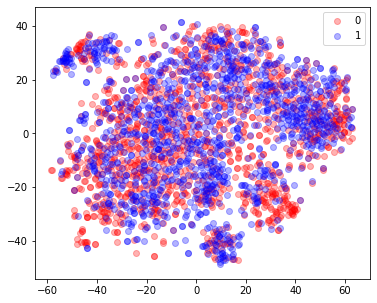

In [104]:
tsne(x_dev[:2500, :], y_dev[:2500])

## Predict the presence of REC from the representation

In [116]:
model = LinearSVC(dual = False) #SGDClassifier(max_iter = 200)
model.fit(x_train, y_train)
print(model.score(x_dev, y_dev))

0.8473
